# AUTOENCODER
This file have purpose to anlysys performance of autoencoder model

reference : https://towardsdatascience.com/generating-new-faces-with-variational-autoencoders-d13cfcb5f0a8
# Header Program

In [1]:
# Import library create by mysel
from library.directory_handle import DirectoryHandle
import library.image_handle as ImageHandle
import library.data_handle as DataHandle

# Import library for plot image
import matplotlib.pyplot as plt

# Import library for manage model part Core Layers
from keras.layers import Input, Flatten, Dense, Reshape, Lambda
# Import library for manage model part Convolution Layers
from keras.layers import Conv2D, Conv2DTranspose
# Import Library for manage model part Model Object
from keras.models import Model
# Import Library for manage model part optimizer
from keras.optimizers import Adam
# Import Library about model 
from keras.utils import plot_model
# Import library for load model
from keras.models import load_model
# Import library operation in Keras tensor object
from keras import backend as K

#Import library for normal process
import numpy as np

Using TensorFlow backend.


# Classification
## Part prepare data

In [ ]:
# Constant data path to collect directory data
PATH_DATA = "/home/zeabus/Documents/supasan/2019_deep_learning/PokemonData" 

# Part parameter in normal program will require to input
crop = True
color = True
rounds = 10 # Round to train data (epoches)

In [ ]:
# Process Read data 
directory_handle = DirectoryHandle( PATH_DATA )
list_label , list_data = directory_handle.group_data()
list_dictionary = directory_handle.group_dictionary()

In [ ]:
width = []
height = []
for data in list_data:
    width , height = ImageHandle.read_size( data , width , height )
plt.scatter( width , height )

In [ ]:
smallest_size = ImageHandle.min_all_square_size1( list_data )
smallest_size = smallest_size if smallest_size % 2 == 0 else smallest_size - 1
latent_size = int( smallest_size * smallest_size / 4 )
latent_size = latent_size * 3 if color else latent_size
print(f'Will manage by resize image to smallest size {smallest_size} square and have latent size {latent_size}')

input_dim = ( smallest_size , smallest_size , 3 if color else 1 )

X_data , Y_data = ImageHandle.prepare_label_data( list_label , list_data , smallest_size , color = color , crop = crop )

In [ ]:
# Before train data first time must split data for train and test
(X_train,Y_train) , (X_test,Y_test) = DataHandle.train_test_split( X_data , Y_data , 8 )
print(f'From {len(X_data)} datas split for train {len(X_train)} and test {len(X_test)}')

## Part Autoencoder Model
Above part is part prepare data for train test and analysis

In [ ]:
# Set up model part encoder
encoder_input = Input( shape = input_dim , name = 'encode_input' )
encoder = encoder_input
encoder = Conv2D( filters = 64,
                kernel_size = (3,3),
                strides=2,
                padding='same',
                activation='relu',
                name = "encoder_convolution_1")(encoder)
encoder = Conv2D( filters = 32,
                kernel_size = (3,3),
                strides=1,
                padding='same',
                activation='relu',
                name = "encoder_convolution_2")(encoder)
encoder = Conv2D( filters = 16,
                kernel_size = (3,3),
                strides=1,
                padding='same',
                activation='relu',
                name = "encoder_convolution_3")(encoder)
shape_before_flatten = (int(smallest_size/2) , int(smallest_size/2) , 16)
encoder = Flatten()(encoder)
encoder_output = Dense( latent_size , name = "encoder_output")(encoder)

encoder_model = Model( encoder_input , encoder_output )
encoder_model.name = "encoder_model"
encoder_model.summary()

In [ ]:
decoder_input = Input( shape = (latent_size,) , name ='decoder_input')
decoder = Dense( np.prod(shape_before_flatten) , name='decoder_input_convolution' )(decoder_input)
decoder = Reshape( shape_before_flatten , name='decoder_input_reshape')(decoder)
decoder = Conv2DTranspose( filters = 32,
                        kernel_size = (3,3),
                        strides=1,
                        padding='same',
                        name='decoder_convolution_1',
                        activation='relu')(decoder)
decoder = Conv2DTranspose( filters = 64,
                        kernel_size = (3,3),
                        strides=2,
                        padding='same',
                        name='decoder_convolution_2',
                        activation='relu')(decoder)
decoder_output = Conv2DTranspose( filters = 3 if color else 1,
                        kernel_size = (3,3),
                        strides=1,
                        padding='same',
                        name='decoder_output',
                        activation='relu')(decoder)
decoder_model = Model( decoder_input , decoder_output )
decoder_model.name = "decoder_model"
decoder_model.summary()

In [ ]:
autoencoder = Model( encoder_input , decoder_model(encoder_output) )
autoencoder.summary()

## Train Model

In [ ]:
optimizer = Adam( lr = 0.0005 ) # set learning
autoencoder.compile( optimizer=optimizer,
                    loss='mean_squared_error',
                    metrics=['accuracy'])
history = autoencoder.fit( [X_train], # Input
                          [X_train], # Output
                         validation_data=( [X_test] , [X_test]),
                         epochs = rounds )

In [ ]:
# Plot traing & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()e

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
autoencoder.save( "classifier/pokemon_autoencoder.h5")

## Result Model

In [ ]:
autoencoder = load_model( "classifier/pokemon_autoencoder.h5" )

In [ ]:
random_index = []
for _ in range(0,10):
    random_index.append( np.random.randint( len( X_test)))
random_index = tuple( set( random_index ) )
data = []
for index in random_index :
    data.append( X_test[ index ] )
data = np.array( data )

In [ ]:
DataHandle.plot_compare( data , autoencoder )

## Part Classifier Model
Above part is model for autoencoder below part will push Fully Connected Layer for classifier

In [ ]:
classifier_input = Input( shape = (latent_size,) , name = "classifier_input" )
classifier = Dense( int( latent_size / 2 ), 
        activation='relu',
        name = 'classifier_network_1' )( classifier_input )
classifier_output = Dense( len(list_label),
        activation='softmax',
        name = 'classifier_output' )( classifier )

classifier_model = Model( classifier_input , classifier_output )
classifier_model.name = "fully_connected"
classifier_model.summary()

In [ ]:
classifier = Model( encoder_input , classifier_model( encoder_output ) )
classifier.name = "classifier_model"
optimizer = Adam( lr = 0.0005 ) # set learning
classifier.compile( optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
classifier.summary()

In [ ]:
# Next we will save weights
for run in range( 0 , len( classifier.layers ) - 1 ):
    classifier.layers[ run ].set_weights( autoencoder.layers[run].get_weights() )
    classifier.layers[ run ].trainable = False
classifier.summary()

In [ ]:
history = classifier.fit( [X_train], # Input
                          [Y_train], # Output
                         validation_data=( [X_test] , [Y_test]),
                         epochs = rounds )

In [ ]:
classifier.save( "classifier/pokemon_autoencoder_classifier.h5")

## Result Model Classifier on AutoEncoder

In [ ]:
classifier = load_model( "classifier/pokemon_autoencoder_classifier.h5" )
predict = classifier.predict( [X_test] )

In [ ]:
DataHandle.result_classifier( predict , np.array( Y_test ) , list_dictionary )

# Genarator Variational Autoencoder

## prepare data

In [2]:
# Constant data path to collect directory data
PATH_DATA = "/home/zeabus/Documents/supasan/2019_deep_learning/AnimeFaceData" 

# Part parameter in normal program will require to input
crop = True
color = True
rounds = 10 # Round to train data (epoches)

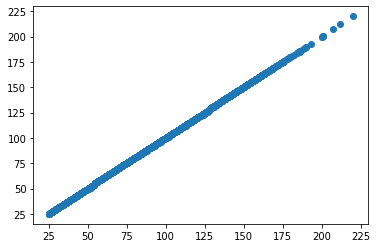

In [3]:
directory_handle = DirectoryHandle( PATH_DATA )
list_file = directory_handle.get_all_file()

width , height = ImageHandle.read_size( list_file )
width = np.array( width )
height = np.array( height )
plt.scatter( width , height )

In [4]:
square_size = int( np.ceil( width.min() ) )
square_size = square_size if square_size % 2 == 0 else square_size + 1
latent_size = int( np.power( square_size , 2 ) / 4 * 3 )
print(f'Will manage by resize image to size {square_size} square and have latent size {latent_size}')

Will manage by resize image to size 26 square and have latent size 507


In [5]:
input_dim = ( square_size , square_size , 3  )

X_data = ImageHandle.read_all_data( list_file , square_size , color = color , crop = crop )
X_train , X_test = DataHandle.split_data( X_data , 18 )

## Part Autoencoder Model
### Part Encoder Model

In [ ]:
# Set up model part encoder
encoder_input = Input( shape = input_dim , name = 'encode_input' )
encoder = encoder_input
encoder = Conv2D( filters = 64,
                kernel_size = (3,3),
                strides=2,
                padding='same',
                activation='relu',
                name = "encoder_convolution_1")(encoder)
encoder = Conv2D( filters = 32,
                kernel_size = (3,3),
                strides=1,
                padding='same',
                activation='relu',
                name = "encoder_convolution_2")(encoder)
encoder = Conv2D( filters = 16,
                kernel_size = (3,3),
                strides=1,
                padding='same',
                activation='relu',
                name = "encoder_convolution_3")(encoder)
encoder = Flatten()(encoder)
encoder_output = Dense( latent_size , name = "encoder_output")(encoder)

encoder_model = Model( encoder_input , encoder_output )
encoder_model.name = "encoder_model"
encoder_model.summary()
shape_before_flatten = encoder_model.layers[-3].output_shape[1:]

### Part Decoder Model

In [ ]:
decoder_input = Input( shape = (latent_size,) , name ='decoder_input')
decoder = Dense( np.prod(shape_before_flatten) , name='decoder_input_convolution' )(decoder_input)
decoder = Reshape( shape_before_flatten , name='decoder_input_reshape')(decoder)
decoder = Conv2DTranspose( filters = 32,
                        kernel_size = (3,3),
                        strides=1,
                        padding='same',
                        name='decoder_convolution_1',
                        activation='relu')(decoder)
decoder = Conv2DTranspose( filters = 64,
                        kernel_size = (3,3),
                        strides=2,
                        padding='same',
                        name='decoder_convolution_2',
                        activation='relu')(decoder)
decoder_output = Conv2DTranspose( filters = 3 if color else 1,
                        kernel_size = (3,3),
                        strides=1,
                        padding='same',
                        name='decoder_output',
                        activation='relu')(decoder)
decoder_model = Model( decoder_input , decoder_output )
decoder_model.name = "decoder_model"
decoder_model.summary()

### Part Auto Encoder Model

In [ ]:
autoencoder = Model( encoder_input , decoder_model(encoder_output) )
autoencoder.name = "autoencoder_model"
autoencoder.summary()

## Train Model

In [ ]:
optimizer = Adam( lr = 0.0005 ) # set learning
autoencoder.compile( optimizer=optimizer,
                    loss='mean_squared_error',
                    metrics=['accuracy'])
history = autoencoder.fit( [X_train], # Input
                          [X_train], # Output
                         validation_data=( [X_test] , [X_test]),
                         epochs = rounds )

In [ ]:
# Plot traing & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
autoencoder.save( "generator/anime_autoencoder.h5")

## Result Model

In [ ]:
autoencoder = load_model("generator/anime_autoencoder.h5")

In [ ]:
random_index = []
for _ in range(0,10):
    random_index.append( np.random.randint( len( X_test)))
random_index = tuple( set( random_index ) )
data = []
for index in random_index :
    data.append( X_test[ index ] )
data = np.array( data )
DataHandle.plot_compare( data , autoencoder )

In [ ]:
def generate_images_from_noise( decoder , n_to_show = 10 ): 
    reconst_images = decoder.predict( np.random.randint( low = 0 , high = 256 , size = ( n_to_show , latent_size ) ) )

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

generate_images_from_noise( autoencoder.layers[-1] , 10 ) 

## Recreate Model VAE
### Part Variational Encoder

In [6]:
# Function output of Variational Encoder
def sampling( args ):
    mean , variance = args
    epsilon = K.random_normal( shape=K.shape( mean ) , mean=0 , stddev=1. )
    return mean + K.exp( variance/2)*epsilon

In [7]:
# Set up model part encoder
encoder_input = Input( shape = input_dim , name = 'encode_input' )
encoder = encoder_input
encoder = Conv2D( filters = 64,
                kernel_size = (3,3),
                strides=2,
                padding='same',
                activation='relu',
                name = "encoder_convolution_1")(encoder)
encoder = Conv2D( filters = 32,
                kernel_size = (3,3),
                strides=1,
                padding='same',
                activation='relu',
                name = "encoder_convolution_2")(encoder)
encoder = Conv2D( filters = 16,
                kernel_size = (3,3),
                strides=1,
                padding='same',
                activation='relu',
                name = "encoder_convolution_3")(encoder)
encoder = Flatten()(encoder)

# Adding layer in case VAE
mean_layer = Dense( latent_size , name = "mean" )(encoder)
variance_layer = Dense( latent_size , name = "variance")(encoder)

encoder_output = Lambda( sampling , name='encoder_output')([mean_layer,variance_layer])

encoder_model = Model( encoder_input , encoder_output )
encoder_model.name = "encoder_model"
encoder_model.summary()
shape_before_flatten = encoder_model.layers[-5].output_shape[1:]

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encode_input (InputLayer)       (None, 26, 26, 3)    0                                            
__________________________________________________________________________________________________
encoder_convolution_1 (Conv2D)  (None, 13, 13, 64)   1792        encode_input[0][0]               
__________________________________________________________________________________________________
encoder_convolution_2 (Conv2D)  (None, 13, 13, 32)   18464       encoder_convolution_1[0][0]      
__________________________________________________________________________________________________
encoder_convolution_3 (Conv2D)  (None, 13, 13, 16)   4624        encoder_convolution_2[0][0]      
______________________________________________________________________________________

### Part Decoder

In [8]:
decoder_input = Input( shape = (latent_size,) , name ='decoder_input')
decoder = Dense( np.prod(shape_before_flatten) , name='decoder_input_convolution' )(decoder_input)
decoder = Reshape( shape_before_flatten , name='decoder_input_reshape')(decoder)
decoder = Conv2DTranspose( filters = 32,
                        kernel_size = (3,3),
                        strides=1,
                        padding='same',
                        name='decoder_convolution_1',
                        activation='relu')(decoder)
decoder = Conv2DTranspose( filters = 64,
                        kernel_size = (3,3),
                        strides=2,
                        padding='same',
                        name='decoder_convolution_2',
                        activation='relu')(decoder)
decoder_output = Conv2DTranspose( filters = 3 if color else 1,
                        kernel_size = (3,3),
                        strides=1,
                        padding='same',
                        name='decoder_output',
                        activation='relu')(decoder)
decoder_model = Model( decoder_input , decoder_output )
decoder_model.name = "decoder_model"
decoder_model.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 507)               0         
_________________________________________________________________
decoder_input_convolution (D (None, 2704)              1373632   
_________________________________________________________________
decoder_input_reshape (Resha (None, 13, 13, 16)        0         
_________________________________________________________________
decoder_convolution_1 (Conv2 (None, 13, 13, 32)        4640      
_________________________________________________________________
decoder_convolution_2 (Conv2 (None, 26, 26, 64)        18496     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 26, 26, 3)         1731      
Total params: 1,398,499
Trainable params: 1,398,499
Non-trainable params: 0
___________________________________________

In [9]:
Vautoencoder = Model( encoder_input , decoder_model(encoder_output) )
Vautoencoder.name = "variational_autoencoder_model"
Vautoencoder.summary()

Model: "variational_autoencoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encode_input (InputLayer)       (None, 26, 26, 3)    0                                            
__________________________________________________________________________________________________
encoder_convolution_1 (Conv2D)  (None, 13, 13, 64)   1792        encode_input[0][0]               
__________________________________________________________________________________________________
encoder_convolution_2 (Conv2D)  (None, 13, 13, 32)   18464       encoder_convolution_1[0][0]      
__________________________________________________________________________________________________
encoder_convolution_3 (Conv2D)  (None, 13, 13, 16)   4624        encoder_convolution_2[0][0]      
______________________________________________________________________

## Compile Model
For variational autoencoder must aware about loss function

In [10]:
LOSS_FACTOR = 1000

def kl_loss( y_true , y_pred ):
    kl_loss =  -0.5 * K.sum(1 + variance_layer - K.square( mean_layer ) - K.exp( variance_layer ), axis = 1)
    return kl_loss

def r_loss( y_true , y_pred ):
    return K.mean( K.square( y_true - y_pred ), axis = [1,2,3] )

def total_loss( y_true , y_pred ):
    return LOSS_FACTOR * r_loss( y_true , y_pred ) + kl_loss( y_true , y_pred )

In [11]:
X_train , X_test = DataHandle.split_data( X_data , 18 )

In [12]:
optimizer = Adam( lr = 0.0005 )
Vautoencoder.compile( optimizer = optimizer,
                     loss = total_loss, 
                     metrics=[ r_loss , kl_loss ] )
#Vautoencoder.compile( optimizer=optimizer,
#                    loss='mean_squared_error',
#                    metrics=['accuracy'] )
X_train = np.array( X_train ).astype( np.float ) / 255
X_test = np.array( X_test ).astype( np.float ) / 255

## Train Model

In [ ]:
history = Vautoencoder.fit( [ X_train ], # Input
                          [ X_train ], # Output
                         validation_data=( [X_test] , [X_test] ),
                         epochs = rounds )

In [ ]:
# Plot traing & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation Mean Square loss values
plt.plot(history.history['r_loss'])
plt.plot(history.history['val_r_loss'])
plt.title('Model Mean Square loss')
plt.ylabel('Mean Square Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation kl loss values
plt.plot(history.history['kl_loss'])
plt.plot(history.history['val_kl_loss'])
plt.title('Model KL loss')
plt.ylabel('KL Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
Vautoencoder.save_weights( "generator/anime_Vautoencoder_weights.h5" )

## Result Model

In [13]:
Vautoencoder.load_weights( "generator/anime_Vautoencoder_weights.h5" )

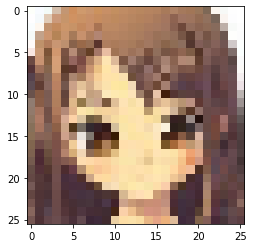

In [14]:
plt.imshow( X_train[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


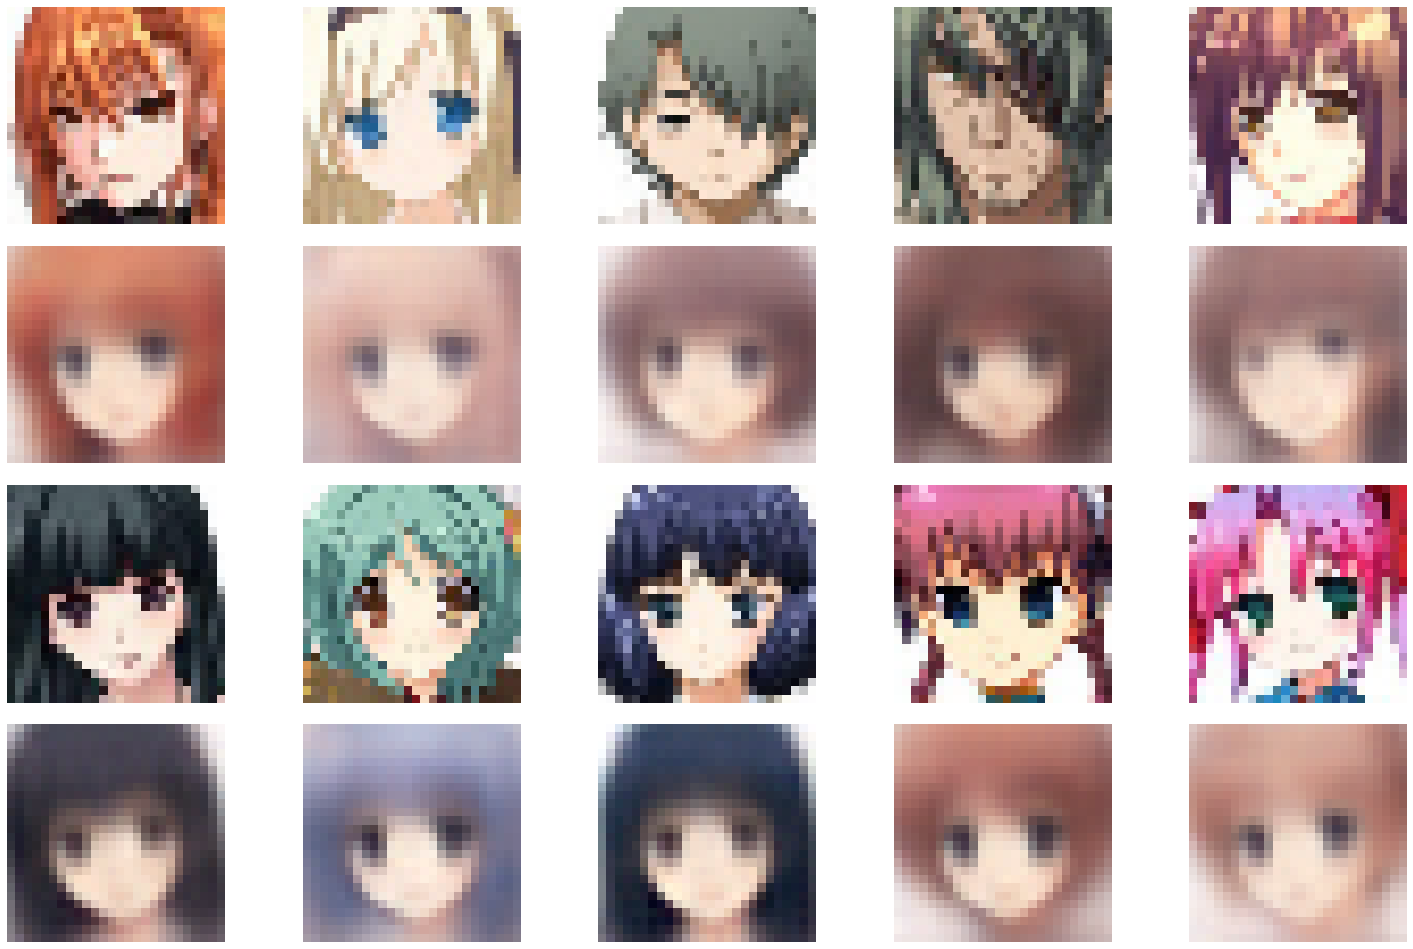

In [15]:
random_index = []
for _ in range(0,10):
    random_index.append( np.random.randint( len( X_test ) ) )
random_index = tuple( set( random_index ) )
data = []
for index in random_index :
    data.append( X_test[ index ] )
data = np.array( data )
DataHandle.plot_compare( data , Vautoencoder , dest_type = float )

In [16]:
vae_decoder = Vautoencoder.layers[-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


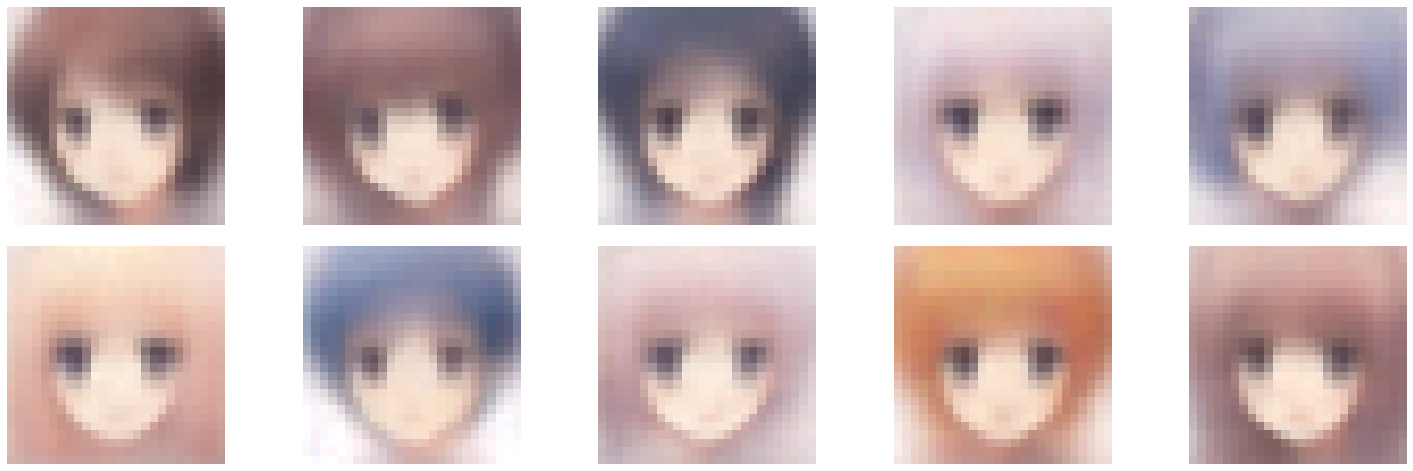

In [20]:
latent_random = np.random.normal( 0 , 1 , size=( 10 , latent_size ))
DataHandle.plot( latent_random , vae_decoder , dest_type = float )

In [18]:
latent_random.shape

(10, 507)